# Вариант 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2 # нужен для подсчета квантилей хи-квадрат распределения
from scipy.stats import norm # нужен для генерации выборки из нормального распределения

In [2]:
def get_chi_2(os, es):
    return np.sum(((os - es) ** 2) / es)

In [3]:
def get_es(n, ps):
    return n * ps

In [4]:
def get_num_intervals(n):
    """
    Так как p_i = 1 / {количество интервалов} и n * p_i > 5
    => n / {количество интервалов} > 5 => {количество интервалов} < n / 5
    => будем возвращать (n // 5) - 1
    """
    return (n // 5) - 1

In [5]:
def get_intervals(num_intervals, p, a, std):
    """
    :param num_intervals: количество интервалов
    :param p: вероятность на каждом интервале
    :param a, std: параметры нормального распределения
    :return: лист интервалов
    """
    intervals = []
    cur_prob = 0
    for i in range(num_intervals):
        l_prob = cur_prob
        r_prob = l_prob + p
        l = norm.ppf(l_prob, loc=a, scale=std)
        r = norm.ppf(r_prob, loc=a, scale=std)
        intervals.append((l, r))
        cur_prob += p
    return intervals

In [6]:
def get_os(xs, intervals):
    """
    :param xs: x1..xn - выборка( из нормального распредения)
    :param intervals: интервали
    :return: частоты точек x1..xn на заданных интервалах
    """
    return [xs[(l < xs) & (xs < r)].size for (l, r) in intervals]

In [7]:
def get_chi_stat(xs, a, std):
    """
    :param xs: выборка
    :param a: среднее
    :param std: дисперсия
    :return: статистику хи-квадрат
    """
    n = xs.size
    num_intervals = get_num_intervals(n)
    p = 1 / num_intervals
    intervals = get_intervals(num_intervals=num_intervals, p=p, a=a, std=std)
    os = get_os(xs, intervals)
    es = get_es(n, np.ones(num_intervals) * p)
    return get_chi_2(np.array(os), es)

Посчитаем ошибку 2-го рода:

$\alpha_1 = P(t(X_1..X_n) \in D_{\alpha} | H_1) = P(\sum\frac{O_i - np_i}{np_i} \in D_{\alpha} | H_1 ) = \\
P((\sum\frac{O_i - np_i'}{np_i'} + x) \in D_{\alpha} | H_1 = \\
P(-x \le \sum\frac{O_i - np_i'}{np_i'} \le \chi^2_{\alpha} - x)
$ , где $x = \sum\frac{O_i - np_i'}{np_i'} - \sum\frac{O_i - np_i}{np_i}, p_i'$ -- вероятности на отрезках при верной альтернативе 

Значит мощность равна:

$\beta = 1 - \alpha_1$

In [8]:
def get_error_two(xs, C, a0, a1, std):
    """
    :param a0: среднее по нулевой гипотезе
    :param a1: среднее по альтернативе
    :param C: квантиль уровня (1-alpha)
    :param std: дисперсия
    :return: ошибка 2-рода
    """
    t = get_chi_stat(xs, a0, std)
    t_ = get_chi_stat(xs, a1, std)
    x = t - t_
    m = get_num_intervals(xs.size)
    return chi2.cdf(C - x, df=m) - chi2.cdf(-x, df=m)

In [9]:
def get_power(xs, C, a0, a1, std):
    """
    :param a0: среднее по нулевой гипотезе
    :param a1: среднее по альтернативе
    :param C: квантиль уровня (1-alpha)
    :param std: дисперсия
    :return: мощность
    """
    return 1 - get_error_two(xs, C, a0, a1, std)

In [10]:
def print_accepting(chi_stat, C):
    """
    Функция печатает решение о принятии или непринятии нулевой гипотезы
    """
    if chi_stat < C:
        print("H0 is accepted")
        print(f'Because chi statistics = {chi_stat} in (0, {C})')
    else:
        print("H0 isn't accepted")
        print(f'Because chi statistics = {chi_stat} not in (0, {C})')

In [11]:
def simple_paint(xs, ys, title, x_name, y_name):
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(xs, ys)
    plt.show()

### Задание 1

Пусть выборка $X_1,..X_n$ из $N(0,1)$

Пусть $H_0: a=0;~H_1: a \neq 0 \\
\Rightarrow $ критическая область при ошибке 1-го рода $\alpha_0=0.05$ равна $(\chi^2_{0.95}, +\infty)$

In [12]:
n = 100000
a = 0
std = 1
xs = norm.rvs(size=n, loc=a, scale=std)
alpha_0 = 0.05
# получаем кол-во интервалов
m = get_num_intervals(n)
# вычисляем границу критической области
C = chi2.ppf(1 - alpha_0, df=m - 1)
# вычисляем статистику хи-квадрат
chi_stat = get_chi_stat(xs, a, std)
print_accepting(chi_stat, C)

H0 is accepted
Because chi statistics = 20141.59262 in (0, 20328.08737478791)


Однако, если $X_1,..,X_n$ на самом деле из $N(1, 1)$

In [13]:
a1 = 1
xs = norm.rvs(size=n, loc=a1, scale=std)
chi_stat = get_chi_stat(xs, a, std)
print_accepting(chi_stat, C)

H0 isn't accepted
Because chi statistics = 194149.69178000002 not in (0, 20328.08737478791)


### Задание 2

Будем изменять среднее в альтернативе от -1 до 2 и смотреть как это сказывается на мощности.

То есть будем смотреть на $H_1:a=(-1,2)$ при шаге $step=0.2$

Зафиксируем прежние параметры(когда основная гипотеза верна)

In [14]:
n = 1000
a = 0
std = 1
xs = norm.rvs(size=n, loc=a, scale=std)
alpha_0 = 0.05
m = get_num_intervals(n)
C = chi2.ppf(1 - alpha_0, df=m - 1)
means = np.linspace(-1, 2, 20)

In [15]:
powers = [get_power(xs=xs, C=C, a0=a, a1=a_1, std=1) for a_1 in means]

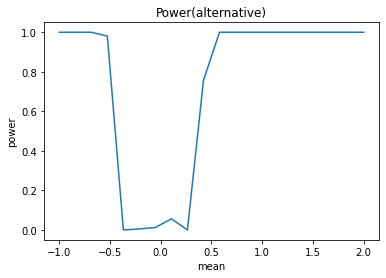

In [16]:
simple_paint(xs=means, ys=powers, title="Power(alternative)", x_name="mean", y_name="power")

Зафиксируем прежние параметры(когда основная гипотеза неверна)

In [17]:
a0 = 0.5
powers = [get_power(xs=xs, C=C, a0=a0, a1=a_1, std=1) for a_1 in means]

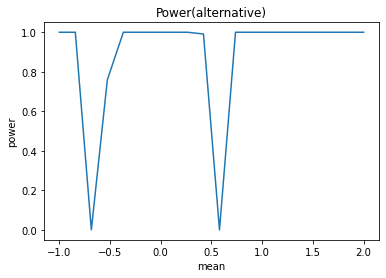

In [18]:
simple_paint(xs=means, ys=powers, title="Power(alternative)", x_name="mean", y_name="power")

Вывод: зависимость мощности критерия против альтернативы -- есть: чем ближе значение альтернативного среднего к основному среднему, тем менее мощным становится критерий 